In [1]:
import pandas as pd
import holidays
from fbprophet import Prophet
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Создание подключения

In [2]:
# Create a dict with parameters of request
connection = {'database': 'default',
              'host': 'https://clickhouse.lab.karpov.courses',
              'user': 'student',
              'password': 'dpo_python_2020'
             }

## Формирование, отправка и получение результата запроса

### Пробный запрос

In [3]:
query = """
SELECT count()
FROM {db}.ldn_listings
"""
rows_num = ph.read_clickhouse(query, connection=connection).rename(columns={'count()': 'num'}).num.sum()

In [4]:
rows_num

85207

In [5]:
ph.execute(query, connection=connection)

b'85207\n'

### Выгрузим из таблицы данные о цене в зависимости от типа жилья.

In [6]:
query = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
FROM {db}.ldn_listings
ORDER BY
    id
LIMIT 1000
"""

room_prices = ph.read_clickhouse(query, connection=connection)

In [7]:
room_prices

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


### Сгруппируем полученный датафрейм по типу жилья и посчитаем 75-й перцентиль цены.

In [8]:
percentile_df = room_prices.groupby('room_type', as_index=False) \
                            .price.quantile(q=0.75) \
                            .rename(columns={'price': '75-quantile'})

In [9]:
percentile_df[percentile_df['room_type'] == 'Private room']

,room_type,75-quantile
2,Private room,70.0


### Выгрузим данные о рейтинге жилья (review_scores_rating). 
#### В запросе отфильтруем пустые значения review_scores_rating и сконвертируем эту колонку в тип float32.

In [10]:
query_review_scores_rating = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
    toFloat32OrNull(review_scores_rating) AS review_scores_rating
FROM
    {db}.ldn_listings
WHERE
    review_scores_rating IS NOT NULL
ORDER BY
    id
LIMIT 1000
"""

review_scores_rating_df = ph.read_clickhouse(query_review_scores_rating, connection=connection)

In [11]:
review_scores_rating_df

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0
...,...,...,...
995,Entire home/apt,165.0,100.0
996,Private room,99.0,93.0
997,Private room,45.0,100.0
998,Private room,20.0,88.0


### 1) Сгруппируем датафрейм по типу жилья и посчитаем среднее для цены и рейтинга 

In [12]:
mean_scores_rating_df = review_scores_rating_df.groupby('room_type', as_index=False) \
                                                    .agg({'price': 'mean', 'review_scores_rating': 'mean'}) \
                                                    .rename(columns={'price': 'price_mean', 'review_scores_rating':'rating_mean'})

In [13]:
mean_scores_rating_df

,room_type,price_mean,rating_mean
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


### 2) Используем sns.scatterplot, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья (параметр hue)

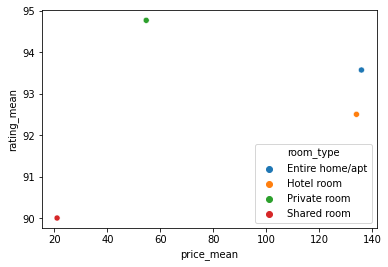

In [14]:
sns.scatterplot(data=mean_scores_rating_df, x='price_mean', y='rating_mean', hue='room_type')

### 3) Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none')

#### Выполним запрос в бд

In [15]:
verification_type_experiencies_query = """
SELECT
    DISTINCT host_id,
    host_verifications
FROM
    {db}.ldn_listings
WHERE
    experiences_offered != 'none'
"""

verification_types_experiencies_df = ph.read_clickhouse(verification_type_experiencies_query, connection=connection)

In [16]:
verification_types_experiencies_df.host_verifications = verification_types_experiencies_df \
                                                                                            .host_verifications \
                                                                                            .apply(lambda x: x.strip('[]').replace("'", '').split(', '))


In [17]:
verification_types_experiencies_df

,host_id,host_verifications
0,54730,"[email, phone, facebook, reviews, offline_gove..."
1,60302,"[email, phone, reviews, jumio, government_id]"
2,67915,"[email, phone, jumio, selfie, government_id, i..."
3,167107,"[email, phone, manual_offline, jumio, offline_..."
4,103583,"[email, phone, reviews, offline_government_id,..."
...,...,...
1356,21558962,"[email, phone, reviews, jumio, government_id]"
1357,21257846,"[email, phone, reviews, jumio, offline_governm..."
1358,34219613,"[email, phone, reviews, jumio, government_id]"
1359,34299581,"[email, phone, google, reviews, jumio, offline..."


#### Посчитаем, сколько раз встречается каждый способ верификации

In [18]:
verification_types_nums = verification_types_experiencies_df.explode('host_verifications').host_verifications.value_counts()
verification_types_nums

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

In [19]:
verification_types_nums.google

34

### 4) Посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируем данные по району и виду впечатления и посчитаем количество объявлений.

In [20]:
experiencies_count_query = """
SELECT 
    neighbourhood_cleansed,
    experiences_offered,
    COUNT() AS experiences_count
FROM
    {db}.ldn_listings
WHERE
    experiences_offered != 'none'
GROUP BY
    neighbourhood_cleansed,
    experiences_offered
ORDER BY
    experiences_count DESC
LIMIT 100
"""

In [21]:
experiencies_by_district_df = ph.read_clickhouse(experiencies_count_query, connection=connection)

In [22]:
experiencies_by_district_df

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [23]:
experiencies_by_district_pivot = experiencies_by_district_df.pivot(
                                                                    index='neighbourhood_cleansed',
                                                                    columns='experiences_offered',
                                                                    values='experiences_count'
                                                                  ) \
                                                                  .fillna(0) \
#                                                                   .reset_index() \                                                                    

In [24]:
experiencies_by_district_pivot

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,0.0,0.0,0.0,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,0.0,0.0,0.0
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,0.0,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,0.0,0.0
Croydon,2.0,3.0,0.0,4.0
Ealing,6.0,13.0,0.0,5.0


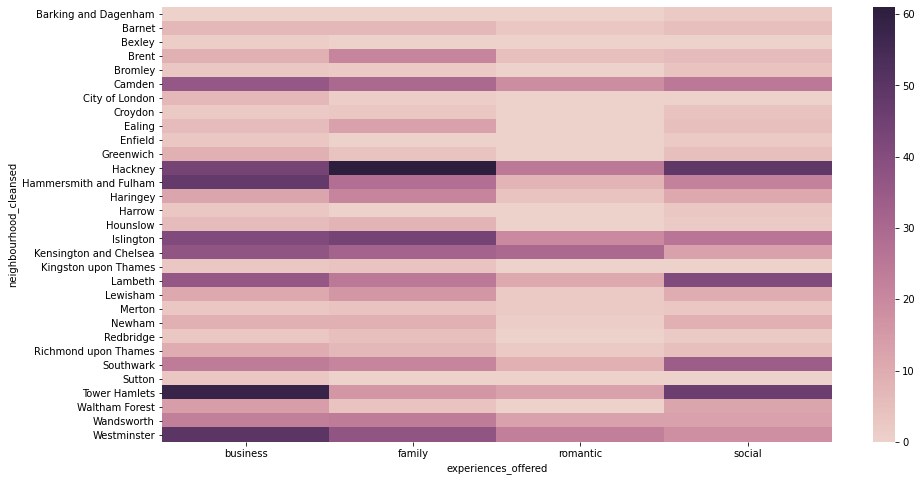

In [25]:
plt.figure(figsize = (15,8))
sns.heatmap(experiencies_by_district_pivot, cmap=sns.cubehelix_palette(as_cmap=True))

### 5) Выгрузим данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления.

In [66]:
room_type_price_query = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM
    {db}.ldn_listings
WHERE
    experiences_offered != 'none'
"""


In [67]:
rooms_prices_df = ph.read_clickhouse(room_type_price_query, connection=connection)

In [68]:
rooms_prices_df

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


#### Построим 2 графика:    

#### 1- исходные распределения цен для каждого типа жилья,


In [77]:
s = 'Private room'
probe = rooms_prices_df.query('@s == room_type and price < 100').sort_values('price')
probe

,room_type,price
1458,Private room,2.639057
872,Private room,2.708050
1485,Private room,2.708050
1486,Private room,2.708050
1416,Private room,2.708050
...,...,...
1395,Private room,5.521461
642,Private room,5.616771
1308,Private room,5.669881
1341,Private room,5.913503


In [70]:
s = 'Private room'
rooms_prices_df.query('@s == room_type').value_counts()

room_type     price
Private room  50.0     45
              45.0     37
              40.0     32
              60.0     31
              30.0     27
                       ..
              81.0      1
              78.0      1
              76.0      1
              73.0      1
              14.0      1
Length: 94, dtype: int64

In [71]:
name = 'Private room'
rooms_prices_df.query('@name == room_type').groupby('price', as_index=False).agg({'room_type': 'count'}).sort_values('room_type', ascending=False)

,price,room_type
33,50.0,45
28,45.0,37
23,40.0,32
43,60.0,31
13,30.0,27
...,...,...
56,76.0,1
54,73.0,1
4,21.0,1
2,17.0,1


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


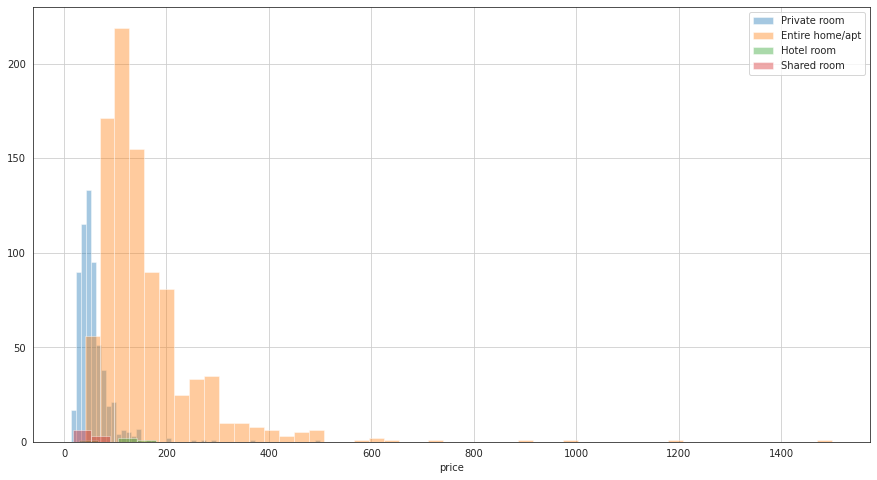

In [72]:
plt.figure(figsize = (15,8))
for i in rooms_prices_df.room_type.unique():
    sns.distplot(rooms_prices_df.query('@i in room_type').price, kde=False, label=i)
sns.set_style("white")
plt.grid()
plt.legend()
plt.show()

#### 2- логарифмированные значения (np.log()).


In [73]:
rooms_prices_logged_df = rooms_prices_df
rooms_prices_logged_df.price = np.log(rooms_prices_logged_df.price)

In [74]:
rooms_prices_logged_df

,room_type,price
0,Private room,4.174387
1,Entire home/apt,4.605170
2,Private room,5.010635
3,Private room,3.806663
4,Private room,3.218876
...,...,...
1543,Entire home/apt,4.605170
1544,Entire home/apt,4.828314
1545,Entire home/apt,5.220356
1546,Entire home/apt,4.700480


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


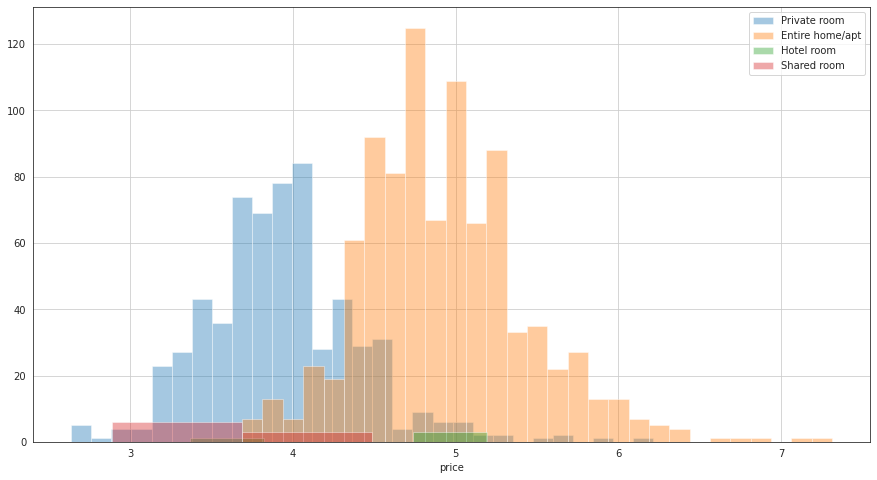

In [75]:
plt.figure(figsize = (15,8))
for j in rooms_prices_logged_df.room_type.unique():
    sns.distplot(rooms_prices_logged_df.query('@j in room_type').price, kde=False, label=j)
sns.set_style("white")
plt.grid()
plt.legend()
plt.show()

### 6) Выгрузим данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года

In [46]:
query_from_01_10 = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    date(toDateTime64OrZero(first_review)) AS first_review_date
FROM
    {db}.ldn_listings
WHERE
    first_review_date > '2010-01-01'
LIMIT 1000
"""

room_type_jan_2010_df = ph.read_clickhouse(query_from_01_10, connection=connection) 

In [48]:
room_type_jan_2010_df

,room_type,price,first_review_date
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [49]:
room_type_jan_2010_df['first_review_year'] = room_type_jan_2010_df.first_review_date.dt.year

In [50]:
room_type_avg_df = room_type_jan_2010_df.sort_values('first_review_year').drop(columns=['first_review_date'])
room_type_avg_df

,room_type,price,first_review_year
0,Private room,65.0,2010
44,Private room,55.0,2010
39,Private room,75.0,2010
38,Entire home/apt,78.0,2010
33,Private room,45.0,2010
...,...,...,...
887,Private room,21.0,2019
277,Private room,105.0,2019
431,Private room,35.0,2019
12,Private room,39.0,2020


In [51]:
room_type_avg_df = room_type_avg_df.groupby(['room_type', 'first_review_year'], as_index=False) \
                                    .agg({'price': 'mean'})
room_type_avg_df

,room_type,first_review_year,price
0,Entire home/apt,2010,103.500000
1,Entire home/apt,2011,128.792450
2,Entire home/apt,2012,135.467255
3,Entire home/apt,2013,137.887634
4,Entire home/apt,2014,154.583328
5,Entire home/apt,2015,159.380951
6,Entire home/apt,2016,99.733330
7,Entire home/apt,2017,111.666664
8,Entire home/apt,2018,125.066666
9,Entire home/apt,2019,301.666656


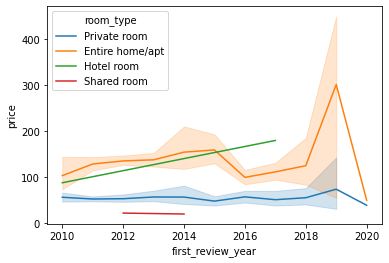

In [52]:
sns.lineplot(data=room_type_jan_2010_df, x='first_review_year', y='price', hue='room_type')